In [1]:
import mesa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import networkx as nx   

from enum import Enum

sns.set(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [145]:
class State(Enum):
    MOVE = 1
    NO_MOVE = 0

In [146]:
def opinion_avg(model):
    return sum(a.opinion for a in model.online_space.get_all_cell_contents())/model.num_agents

def combined_info_avg(model):
    return sum(a.combined_info for a in model.online_space.get_all_cell_contents())/model.num_agents

def mobility_count(model):
    return sum(1 for a in model.online_space.get_all_cell_contents() if a.mobility_state is State.MOVE)
    
def no_mobility_count(model):
    return sum(1 for a in model.online_space.get_all_cell_contents() if a.mobility_state is State.NO_MOVE)

def mobility_rate(model):
    return mobility_count(model)/model.num_agents

In [1]:
class opinionsModel(mesa.Model):
    
    '''
    Model parameters:
        N = population size
        alpha = the weight of the opinions in influencing the constructed decisions
        beta = the weight of the observed mobility in influencing the constructed decisions
        h = the height of the physical grid
        w = the width of the pysical grid
        
    Agents parameters 
        PT = peer trust
        R = risk sensitivty 
        B = rendency to share
        dt = risk tolerance threshold 
        
            value is -1 : randomly assigned from unifrom distribution 
            other values : all agents will share this value 
    '''
    def __init__(self, N = 10, w = 10 , h = 10 , alpha = 0.5 , beta = 0.5, PT = -1, B = -1, R = -1, dt = -1):
      
        
        self.num_agents = N
        self.width = w
        self.height = h
        
        self.PT = PT
        self.B = B
        self.R = R
        self.dt = dt
        
        self.alpha = alpha
        self.beta = beta

        self.G = nx.complete_graph(n = self.num_agents)
        
#         avg_node_degree = 5
#         prob = avg_node_degree / self.num_agents
#         self.G = nx.erdos_renyi_graph(n=self.num_agents, p=prob)
        
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "op_avg": opinion_avg,
                "combined_info_avg": combined_info_avg,
#                 "moving" : mobility_count,
#                 "not_moving" : no_mobility_count,
                "mobility_rate" : mobility_rate,
            },
            agent_reporters = {
                "opinion" : "opinion", 
#                 "physical_pos": "physical_pos",
#                 "peer_trust" : "peer_trust",
#                 "risk_sensitivity": "risk_sensitivity",
#                 "tendency_to_share" : "tendency_to_share",
#                 "moving_neighbors" : "moving_neighbors",
                "observed_mobility": "observed_mobility_rate",
                
                "online_info":"online_info",
                "offline_info" : "offline_info",
                "combined_info" : "combined_info",
                "decision_th" : "decision_th",
                "old_decision":"old_decision",
                "decision" : "decision",
#                 "mobility_state" : "mobility_state",
            }
        )

        self.physical_space = mesa.space.MultiGrid(width = self.width , height = self.height, torus = True)
        self.online_space = mesa.space.NetworkGrid(g = self.G)
        
        self.schedule = mesa.time.RandomActivation(self)
                
        for i in range(self.num_agents):
            x = random.randrange(self.physical_space.width)
            y = random.randrange(self.physical_space.height)
            
            physical_pos = (x , y)
            online_node = i
                        
            a = userAgent(i, self, self.PT, self.B, self.R, self.dt, physical_pos, online_node)
            
            self.physical_space.place_agent(a, physical_pos)
            self.online_space.place_agent(a, online_node)
            
            self.schedule.add(a)
          
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)  
        
        for a in self.schedule.agents:
            a.old_decision = a.decision
            

NameError: name 'mesa' is not defined

In [777]:
class userAgent(mesa.Agent):
    '''
    Agents parameters 
        PT = peer trust
        R = risk sensitivty 
        B = rendency to share
        dt = risk tolerance threshold 
        
            value is -1 : randomly assigned from unifrom distribution 
            other values : all agents will share this value 
    '''
    
    def __init__( self, unique_id, model, PT, B, R, dt, pos, node):
        
        super().__init__(unique_id, model)
        
        self.physical_pos = pos
        self.online_node = node
        
        
        #1. opinion
        self.opinion = random.uniform(0, 1) 
#         self.old_opinion = self.opinion
    
        # 2. peer trust
        if PT == -1: 
            self.peer_trust = random.uniform(0, 1)
        else:
            self.peer_trust = PT
        
        # 3. tendency to share
        if B == -1:
            self.tendency_to_share = random.uniform(0, 1)
        else:
            self.tendency_to_share = B
        
        # 4. risk sensitivity
        if R == -1:
            temp = random.uniform(0, 1)
            if temp < 1.0/3.0:
                self.risk_sensitivity = 0 
            else:
                temp2 = random.uniform(0, 1)
                if temp2 < 0.5:
                    self.risk_sensitivity = 2 
                else:
                    self.risk_sensitivity = 1 
        else:
            self.risk_sensitivity = R
                
        # 5. risk tolerance threshold
        if dt == -1:
            self.decision_th = random.uniform(0, 1)
        else:
            self.decision_th = dt

            
        # 6. nighbours observed mobility
        self.moving_neighbors = 0
        self.observed_mobility_rate = 0
        
        # 7. final decision
        self.online_info = 0
        self.offline_info = 0
        self.combined_info = 0
        
        self.decision = random.randint(0, 1)
        self.old_decision = self.decision
            
            
        self.mobility_state = self.set_mobility_state(self.decision)
  

    def set_mobility_state(self, decision):
        if decision == 0:
            return State.NO_MOVE
        else:
            return State.MOVE
        
        
    def update_opinion(self):

        neighbors = self.model.online_space.get_neighborhood(self.online_node, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.online_space.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                if self.risk_sensitivity == 0:
                    self.opinion = self.opinion / 2.0
                elif self.risk_sensitivity == 2:
                    self.opinion = (1.0 + self.opinion) / 2.0
            
            # current agent speek
            speak_prob = saved_opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                if other_agent.risk_sensitivity == 0:
                    other_agent.opinion = other_agent.opinion / 2.0
                elif other_agent.risk_sensitivity == 2:
                    other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
    
   

    def get_nighbours_mobility_rate(self):
        cellmates = self.model.physical_space.get_cell_list_contents([self.physical_pos])
        if len(cellmates) > 1:
            self.moving_neighbors = sum(1 for a in cellmates if a.unique_id != self.unique_id and a.old_decision == 1)
            self.observed_mobility_rate = self.moving_neighbors / (len(cellmates)-1)
        
        
    def make_mobililty_decision(self, opinion):

        self.get_nighbours_mobility_rate()
        
        self.online_info = self.model.alpha * self.opinion
        self.offline_info = (1 - self.model.alpha) * (1 - self.observed_mobility_rate)
        
        self.combined_info = self.online_info + self.offline_info
    
        if self.combined_info < self.decision_th:
            self.decision = 1
        elif self.combined_info >= self.decision_th:
            self.decision = 0
            
        self.mobility_state = self.set_mobility_state(self.decision)
        
        # updtate opinion:
        self.opinion = self.combined_info
#         self.opinion = ( self.model.beta * self.opinion ) + ( (1 - self.model.beta) * self.combined_info )

        
    def step(self):
        self.make_mobililty_decision(self.opinion)
        self.update_opinion()
        


### simple test

In [3]:
model = opinionsModel(N = 50 , w = 3 , h = 3)
num_steps = 100
for _ in range(num_steps):
    model.step()

NameError: name 'opinionsModel' is not defined

In [ ]:
num_steps = 100
for _ in range(num_steps):
    model.step()

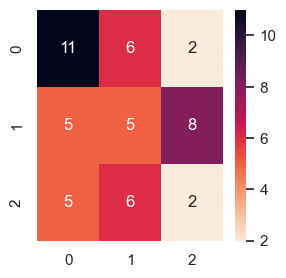

In [779]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

In [780]:
# nx.draw(model.G)

In [781]:
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

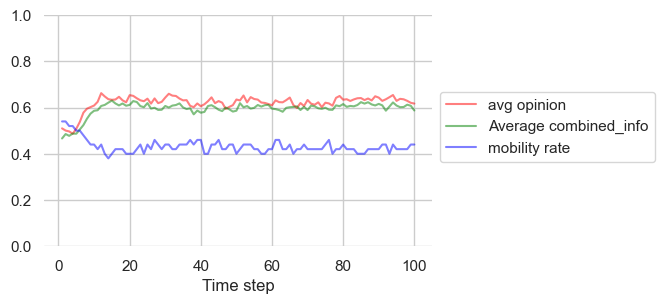

In [782]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()



# plotting
# for i in range(500):
#     sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

sns.lineplot(x = subdata.index , y = "op_avg" , data = subdata , color = "red" , alpha = 0.5 , label = "avg opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , color = 'green' , alpha = 0.5 , label = "Average combined_info")

sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , color = "blue" , alpha = 0.5 , label = "mobility rate") 
  
# sns.lineplot(x="Step", y="online_info", data=info_data, label = "Average opinion", color = 'red', alpha = 0.4)
# sns.lineplot(x="Step", y="offline_info", data=info_data, label = "Average observed_mobility", color = 'green', alpha = 0.4)



plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

## baseline:

In [783]:
# model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.5 , beta = 0.5, PT = 0.5, B = 0.5, R = 1, dt = 0.5)
model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.5 , beta = 0.5)


num_steps = 100
for _ in range(num_steps):
    model.step()

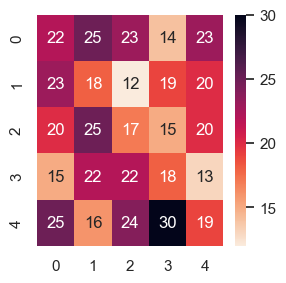

In [784]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

In [785]:
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

In [786]:
agents_data.query("AgentID == 0")

,,opinion,observed_mobility,online_info,offline_info,combined_info,decision_th,old_decision,decision
Step,AgentID,,,,,,,,
0,0,0.924436,0.000000,0.000000,0.000000,0.000000,0.965481,1,1
1,0,0.372196,0.458333,0.462218,0.270833,0.733051,0.965481,1,1
2,0,0.190111,0.416667,0.186098,0.291667,0.477765,0.965481,1,1
3,0,0.391337,0.250000,0.095055,0.375000,0.470055,0.965481,1,1
4,0,0.431331,0.291667,0.169499,0.354167,0.523665,0.965481,1,1
...,...,...,...,...,...,...,...,...,...
96,0,0.436440,0.166667,0.152071,0.416667,0.568738,0.965481,1,1
97,0,0.453748,0.208333,0.218220,0.395833,0.614053,0.965481,1,1
98,0,0.392981,0.208333,0.226874,0.395833,0.622707,0.965481,1,1


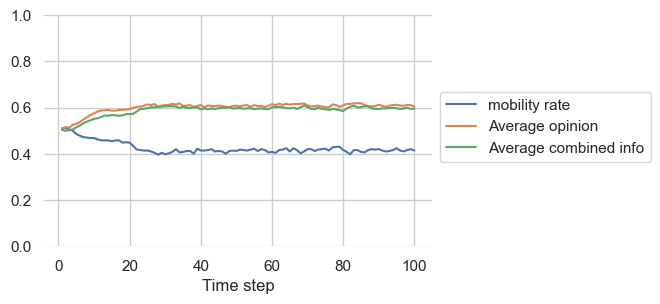

In [787]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()



# plotting
# for i in range(500):
#     sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

# sns.lineplot(x = subdata.index , y = "op_avg" , data = subdata , color = "red" , alpha = 0.5 , label = "avg opinion")

sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 

sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
# sns.lineplot(x="Step", y="observed_mobility", data=info_data, label = "Average observed mobility")

sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")

# info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# sns.lineplot(x="Step", y="online_info", data=info_data, label = "Average online info")
# sns.lineplot(x="Step", y="offline_info", data=info_data, label = "Average offline info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

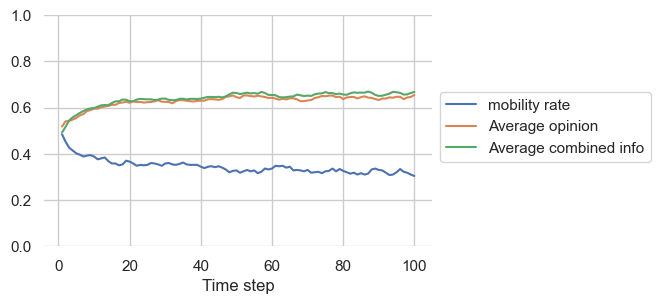

In [776]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()



# plotting
# for i in range(500):
#     sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

# sns.lineplot(x = subdata.index , y = "op_avg" , data = subdata , color = "red" , alpha = 0.5 , label = "avg opinion")

sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 

sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
# sns.lineplot(x="Step", y="observed_mobility", data=info_data, label = "Average observed mobility")

sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

## different combination of the model parameters

In [700]:
model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.8 , beta = 0.2)

num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

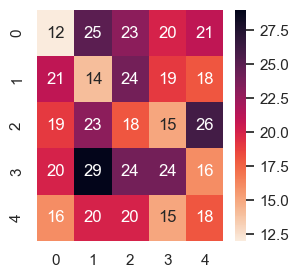

In [701]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

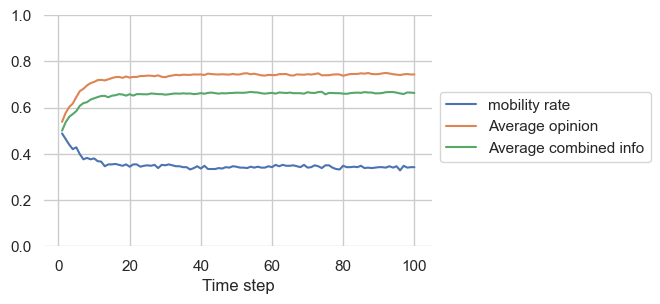

In [654]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

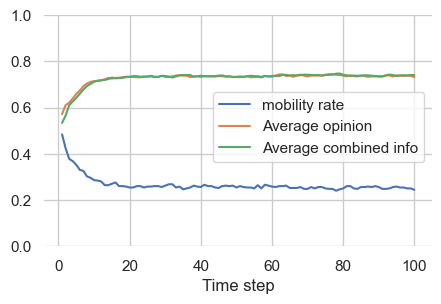

In [702]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

In [643]:
# plt.figure(figsize=(5,  3))

# for pos in ['right', 'top', 'bottom', 'left']: 
#     plt.gca().spines[pos].set_visible(False) 
    
    
# subdata = model_data[1:]

# # plotting
# # for i in range(500):
# #     sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

# sns.lineplot(x = subdata.index , y = "op_avg" , data = subdata , color = "red" , alpha = 0.5 , label = "avg opinion")
# sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , color = 'green' , alpha = 0.5 , label = "Average combined_info")
# sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , color = "blue" , alpha = 0.5 , label = "mobility rate") 
  
# plt.ylim(0,1)
# plt.xlabel("Time step")
# plt.ylabel("")

# plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

# plt.show()

In [703]:
model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.6 , beta = 0.4)

num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

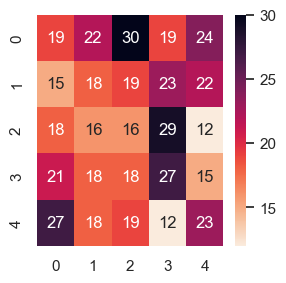

In [704]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

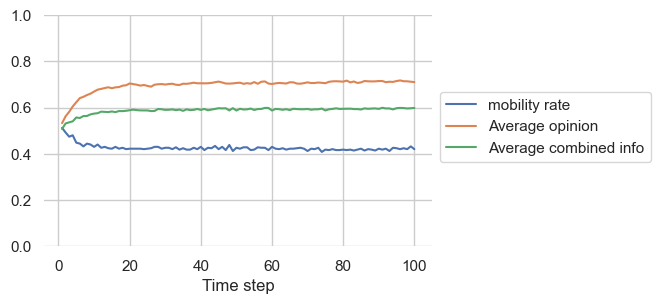

In [657]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

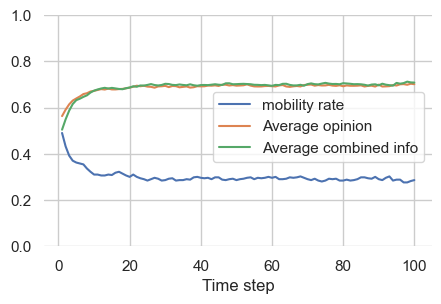

In [705]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

In [706]:
model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.4 , beta = 0.6)

num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

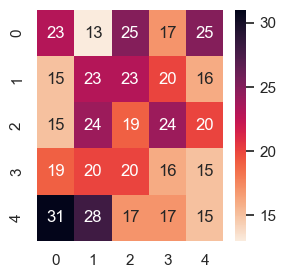

In [707]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

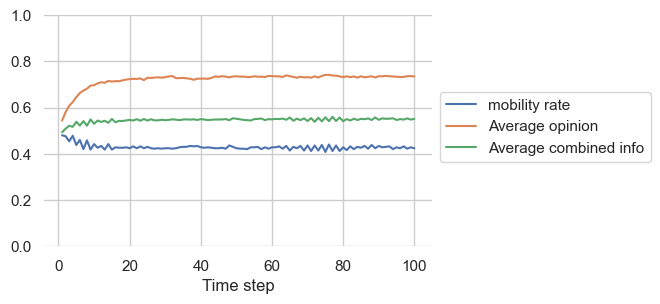

In [660]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

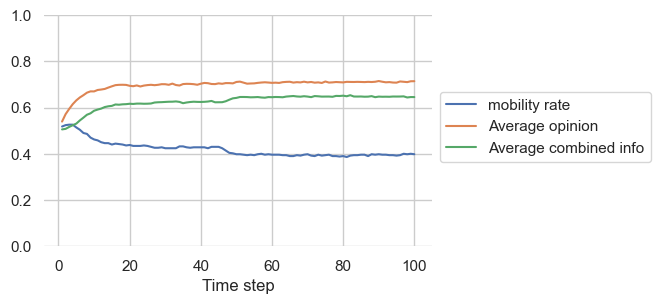

In [708]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

In [709]:
model = opinionsModel(N = 500, w = 5 , h = 5 , alpha = 0.2 , beta = 0.8)

num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

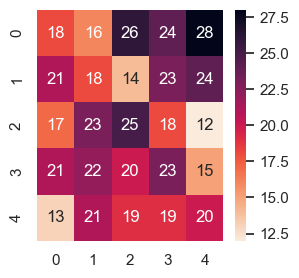

In [710]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

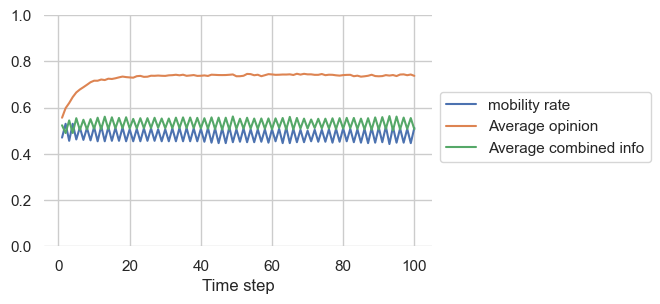

In [663]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

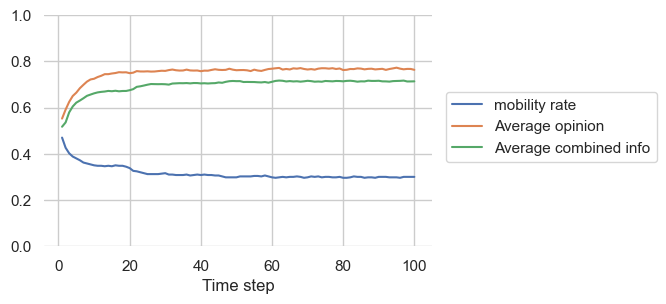

In [717]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1.6, 0.7), ncol=1)

plt.show()

In [718]:
model = opinionsModel(N = 10, w = 1 , h = 1 , alpha = 0.2 , beta = 0.8)

num_steps = 50
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

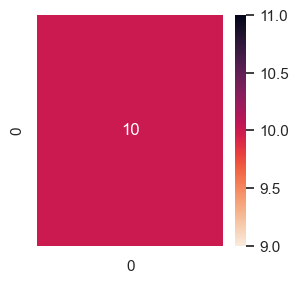

In [719]:
agent_counts = np.zeros((model.physical_space.width, model.physical_space.height))
for cell_content, (x, y) in model.physical_space.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
    
g = sns.heatmap(agent_counts, annot=True, cmap="rocket_r")
g.figure.set_size_inches(3, 3)

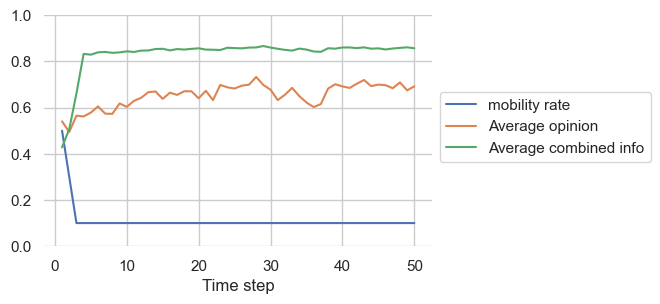

In [720]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
subdata = model_data[1:]

info_data = agents_data.query("Step > 0").groupby("Step")[["online_info", "offline_info","observed_mobility", "opinion"]].mean().reset_index()

# plotting
sns.lineplot(x = subdata.index , y = "mobility_rate" , data = subdata , label = "mobility rate") 
sns.lineplot(x="Step", y="opinion", data=info_data, label = "Average opinion")
sns.lineplot(x = subdata.index , y = "combined_info_avg" , data = subdata , label = "Average combined info")


plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("")

plt.legend(bbox_to_anchor=(1, 0.7), ncol=1)

plt.show()

In [721]:
model_data

,op_avg,combined_info_avg,mobility_rate
0,0.542873,0.000000,0.6
1,0.540313,0.428015,0.5
2,0.494245,0.506813,0.3
3,0.564996,0.660751,0.1
4,0.561453,0.832291,0.1
5,0.578102,0.829084,0.1
6,0.605099,0.839074,0.1
7,0.573712,0.840842,0.1
8,0.572954,0.836870,0.1
9,0.617823,0.838848,0.1


In [242]:
model = opinionsModel(N = 500, alpha = 0.8 , beta = 0.2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

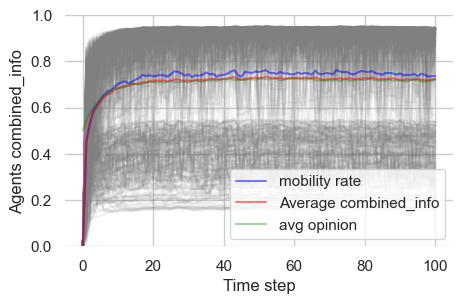

In [212]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

In [199]:
# plt.figure(figsize=(5,  3))

# for pos in ['right', 'top', 'bottom', 'left']: 
#     plt.gca().spines[pos].set_visible(False) 
    
# subdata = model_data[model_data.index > 0]

# sns.lineplot(x=subdata.index, y="mobility_rate", data=subdata, color="blue", alpha=0.3, label= "mobility rate") 
# sns.lineplot(x=subdata.index, y="op_avg", data=subdata, color= "red", alpha=0.3, label= "avg opinion")
    
# plt.ylim(0,1)    
# plt.xlabel("Time Step")
# plt.ylabel("")
# plt.show()

In [213]:
model = opinionsModel(N = 500, alpha = 0.2 , beta = 0.8)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

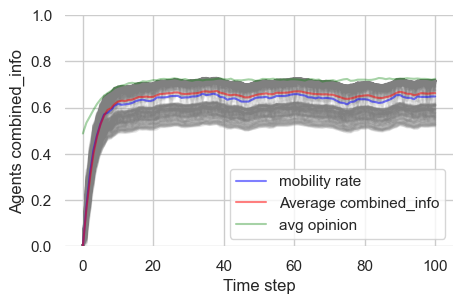

In [214]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

### plot agents individual collected infomration (alpha 0.5, beta 0.5)

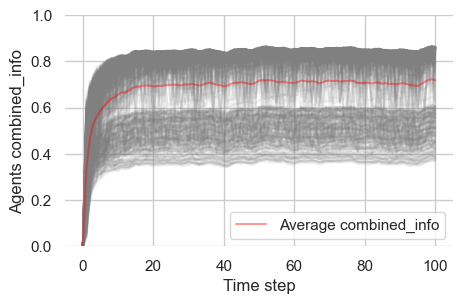

In [217]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

### groub by decision threshold 

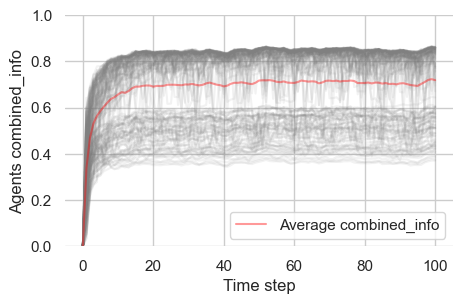

In [220]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['decision_th'])[0] <= 0.3:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

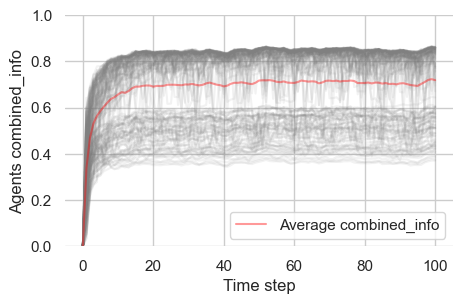

In [221]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['decision_th'])[0] < 0.3 and list(agents_data.query(f"AgentID == {i}")['decision_th'])[0] < 0.7:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

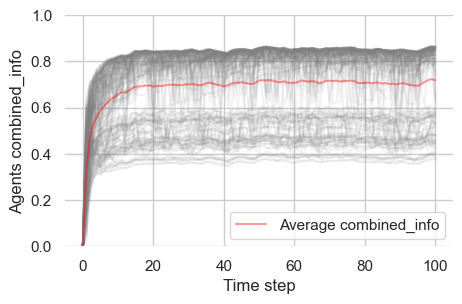

In [222]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['decision_th'])[0] >= 0.7:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

### groub by risk sensitivty

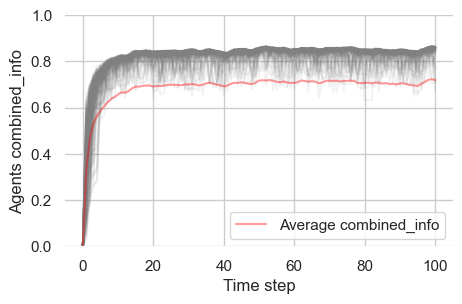

In [223]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    

# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

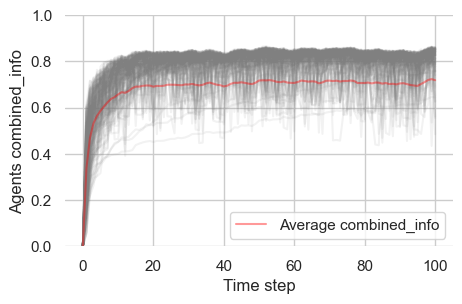

In [224]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    

# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

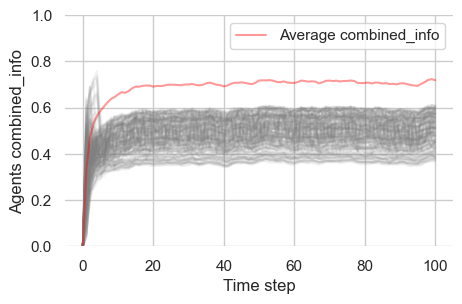

In [225]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    

# plotting
for i in range(500):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)


sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.4)

plt.ylim(0,1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

## population of alarmist agents:


In [226]:
model = opinionsModel(N = 500, alpha = 0.5 , beta = 0.5, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

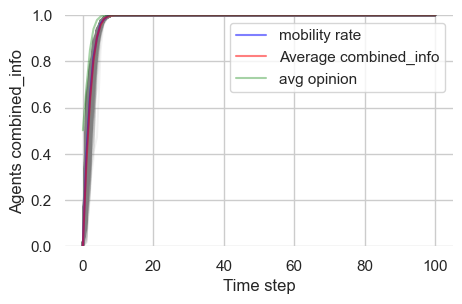

In [230]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

In [231]:
model = opinionsModel(N = 500, alpha = 0.2 , beta = 0.8, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

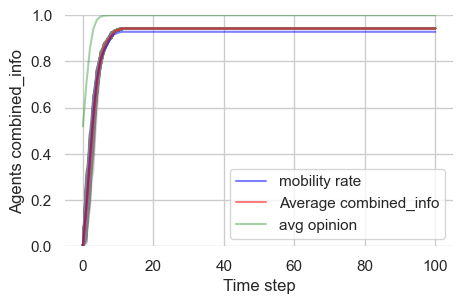

In [232]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

In [233]:
model = opinionsModel(N = 500, alpha = 0.8 , beta = 0.2, R = 2)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

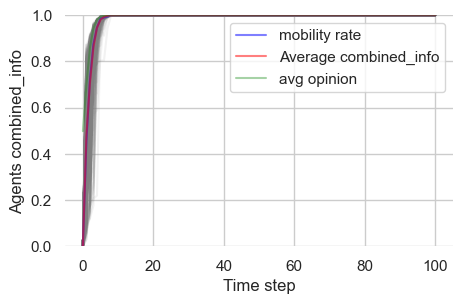

In [234]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

## population of non-alarmist agents

In [237]:
model = opinionsModel(N = 500, alpha = 0.5 , beta = 0.5, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

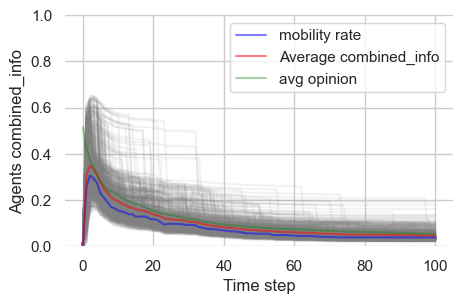

In [238]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

In [235]:
model = opinionsModel(N = 500, alpha = 0.2 , beta = 0.8, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

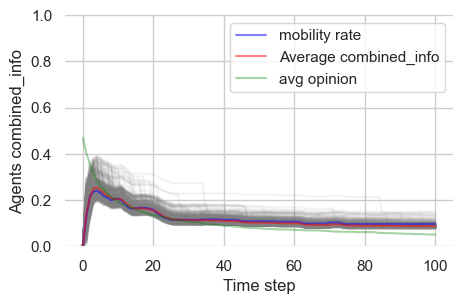

In [236]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()

In [239]:
model = opinionsModel(N = 500, alpha = 0.8 , beta = 0.2, R = 0)
num_steps = 100
for _ in range(num_steps):
    model.step()
    
model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

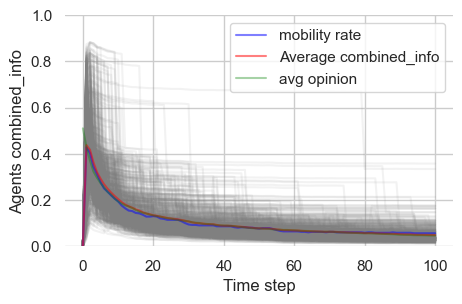

In [240]:
plt.figure(figsize=(5,  3))

for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
    
    
# plotting
for i in range(500):
    sns.lineplot(x = "Step", y = "combined_info", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)



sns.lineplot(x=model_data.index, y="mobility_rate", data=model_data, color="blue", alpha=0.5, label= "mobility rate") 
sns.lineplot(x="Step", y="combined_info", data=agents_data.groupby("Step")["combined_info"].mean().reset_index(), label = "Average combined_info", color = 'red', alpha = 0.5)
sns.lineplot(x=model_data.index, y="op_avg", data=model_data, color= "green", alpha=0.35, label= "avg opinion")

  
plt.ylim(0, 1)
plt.xlabel("Time step")
plt.ylabel("Agents combined_info")

plt.legend()

plt.show()